>>## Feelling Recognition NLP project using LSTM

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense , Dropout,LSTM

%matplotlib inline

In [9]:
len(open('data/test.txt','r').readlines())

2000

In [10]:
len(open('data/train.txt','r').readlines())

16000

In [11]:
len(open('data/val.txt','r').readlines())

2000

In [21]:
open('data/test.txt','r').readlines()[14]

'i find myself in the odd position of feeling supportive of;love\n'

In [20]:
open('data/train.txt','r').readlines()[14]

'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious;joy\n'

In [19]:
open('data/val.txt','r').readlines()[14]

'i walked out of there an hour and fifteen minutes later feeling like i had been beaten with a stick and then placed on the rack and stretched;sadness\n'

## read the training data

In [34]:
with open('data/train.txt','r') as file:
    data = file.readlines()
    print(data)

['i didnt feel humiliated;sadness\n', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness\n', 'im grabbing a minute to post i feel greedy wrong;anger\n', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love\n', 'i am feeling grouchy;anger\n', 'ive been feeling a little burdened lately wasnt sure why that was;sadness\n', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise\n', 'i feel as confused about life as a teenager or as jaded as a year old man;fear\n', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy\n', 'i feel romantic too;love\n', 'i feel like i have to make the suffering i m seeing mean something;sadness\n', 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter;joy\n', 'i think 

In [39]:
x = []
y = []
for i in range(len(open('data/train.txt','r').readlines())):
    splited = data[i].split(';')
    x.append(splited[0])
    y.append(splited[1])    

In [40]:
x[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [43]:
y[1]

'sadness\n'

In [45]:
len(x),len(y)    # i got the x and y data

(16000, 16000)

In [47]:
for i in range(len(open('data/train.txt','r').readlines())):
    cleaned = y[i].replace('\n','')
    y[i] = cleaned

In [48]:
y[1]       # i cleaned the y data

'sadness'

In [79]:
train = pd.DataFrame({'text':x,'label':y})
train.head()           # create data frame

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [81]:
train['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [58]:
values = list(train['label'].value_counts().values)
key = list(train['label'].value_counts().keys())

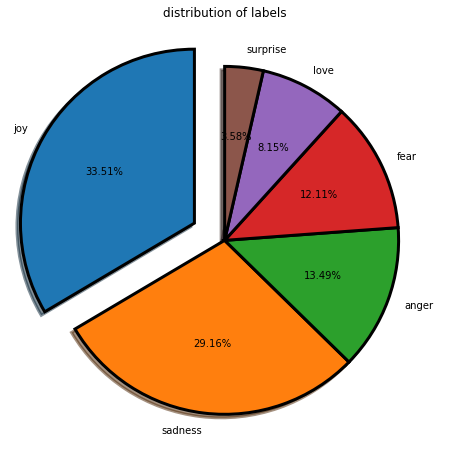

In [76]:
plt.figure(figsize=(8,8))
ex = [0.2,0,0,0,0,0]
plt.pie(values,labels=key,shadow=True,wedgeprops={'edgecolor':'k','lw':'3'},explode=ex,startangle=90,autopct='%1.2f%%')
plt.title('distribution of labels')
plt.show()

# most of the priority of joy 
# visualization of labels

In [82]:
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## text pre-processing

In [91]:
(train['text'].map(len)).max()  # maximum length of sentence in my text

300

In [92]:
(train['text'].map(len)).min()  # minimum length of sentence in my text

7

In [107]:
(train[train['text'].map(len)==(train['text'].map(len)).min()]['text'].values)[0]  # sentence of minimum lenght


'one day'

In [108]:
(train[train['text'].map(len)==(train['text'].map(len)).max()]['text'].values)[0]  # sentence of maximum lenght


'i hope that those of you who actauly found this and read it feel possibly inspired to go out and buy some of these items or even go through storage and see what clothes of yours your mom saved and that you still have a hope of fitting in and mix up your wardrobe for this summer and have a little fun'

## i fetched the all those records which having the length greater than 50

In [114]:
final_train = train[train['text'].map(len)>50]
final_train.head()

,text,label
1,i can go from feeling so hopeless to so damned...,sadness
3,i am ever feeling nostalgic about the fireplac...,love
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear


In [117]:
train = final_train.reset_index().drop('index',axis=1)
train.head()

,text,label
0,i can go from feeling so hopeless to so damned...,sadness
1,i am ever feeling nostalgic about the fireplac...,love
2,ive been feeling a little burdened lately wasn...,sadness
3,ive been taking or milligrams or times recomme...,surprise
4,i feel as confused about life as a teenager or...,fear


In [118]:
train.shape

(12355, 2)

In [122]:
# to remove stopwords and performe stemming

ps = PorterStemmer()
for i in range(len(train)):
    content = re.sub('[^a-zA-Z]',' ',train['text'][i])
    content = content.lower()
    ls_of_word = nltk.word_tokenize(content)
    removed_stopwords = [ps.stem(word) for word in ls_of_word if word not in set(stopwords.words('english'))]
    train['text'][i] = ' '.join(removed_stopwords)
    


In [126]:
train.head()['text'][0]    # removed stopwords and performed stemming

'go feel hopeless damn hope around someon care awak'

In [127]:
# define the vocabulary size
vocabulary_size = 10000


In [131]:
one_hoted = [one_hot(sentence,vocabulary_size) for sentence in train['text']]
one_hoted

[[8633, 5137, 6363, 3455, 7388, 107, 5135, 1516, 7541],
 [7077, 5137, 6913, 8076, 5388, 6377, 2945],
 [2415, 5137, 9670, 5494, 1763, 758, 5538],
 [2415,
  827,
  2806,
  8884,
  9444,
  5036,
  2415,
  3050,
  4672,
  3676,
  4679,
  7193,
  5137,
  5461,
  9949],
 [5137, 9884, 8540, 1116, 6545, 7122, 4909, 6797],
 [781, 7122, 5137, 781, 7446, 779, 9183, 1890, 7081],
 [5137, 5461, 4965, 7582, 7574, 2104, 7906],
 [5137, 2441, 4390, 3134, 9847, 3308, 6705, 4599],
 [9722, 1202, 8884, 7122, 5137, 9906],
 [4561,
  9790,
  1046,
  2316,
  3284,
  6296,
  9807,
  6276,
  7342,
  8884,
  515,
  8017,
  8540,
  6036,
  4905,
  6004,
  160,
  9885,
  7013,
  5137,
  9670,
  5540],
 [3350, 5137, 3953, 724, 4624, 9459, 9870, 9117, 6378, 724, 8344],
 [5137, 193, 8012, 5944, 4497, 1047, 6711, 9452],
 [5137, 6774, 6630, 5942, 8081, 9590, 3787, 9590],
 [5137,
  1983,
  304,
  9372,
  6032,
  3145,
  5137,
  4735,
  5336,
  9016,
  153,
  3734,
  5007,
  4171,
  6076,
  7052,
  7645,
  9642,
  8698],
 

In [134]:
len(one_hoted),train.shape       # smae length

(12355, (12355, 2))

In [165]:
train['text'][1]

'ever feel nostalg fireplac know still properti'

In [144]:
one_hoted[1]

[7077, 5137, 6913, 8076, 5388, 6377, 2945]

In [166]:
len(one_hoted[1])

7

In [167]:
len(train['text'][1].split())

7

In [164]:
len(new_ls[1])

7

## do pad_sequnce to equalize the shape of the sentence

In [170]:
maximum_length_of_sentence = train['text'].map(len).max()
maximum_length_of_sentence

208

In [172]:
train_data  = pad_sequences(one_hoted,padding='pre',maxlen=maximum_length_of_sentence)
train_data

array([[   0,    0,    0, ..., 5135, 1516, 7541],
       [   0,    0,    0, ..., 5388, 6377, 2945],
       [   0,    0,    0, ..., 1763,  758, 5538],
       ...,
       [   0,    0,    0, ..., 1301, 3349, 9665],
       [   0,    0,    0, ..., 5712, 3292, 5450],
       [   0,    0,    0, ..., 5137, 7963, 8308]])

In [175]:
train_data.shape         # i got  my cleaned x data and now i will labelize the y data

(12355, 208)

## to labelize the y data

In [197]:
label_encode = dict(list(zip(list(train['label'].value_counts().index),[i for i in range(0,6)])))
label_encode

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

In [199]:
y = train['label'].map(label_encode)

In [200]:
y.value_counts()

0    4250
1    3443
2    1625
3    1502
4    1080
5     455
Name: label, dtype: int64

## to declare the model & compilation of the model

In [225]:
vocabulary_size,maximum_length_of_sentence

(10000, 208)

In [209]:
model  = Sequential()
model.add(Embedding(vocabulary_size,500,input_length=maximum_length_of_sentence))
model.add(Dropout(0.3))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [210]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 208, 500)          5000000   
                                                                 
 dropout_2 (Dropout)         (None, 208, 500)          0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               560800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 5,562,006
Trainable params: 5,562,006
Non-trainable params: 0
_________________________________________________________________


In [212]:
train_data.shape

(12355, 208)

In [217]:
train_dataa = np.array(train_data)
train_dataa

array([[   0,    0,    0, ..., 5135, 1516, 7541],
       [   0,    0,    0, ..., 5388, 6377, 2945],
       [   0,    0,    0, ..., 1763,  758, 5538],
       ...,
       [   0,    0,    0, ..., 1301, 3349, 9665],
       [   0,    0,    0, ..., 5712, 3292, 5450],
       [   0,    0,    0, ..., 5137, 7963, 8308]])

In [219]:
lab  = np.array(y)
lab

array([1, 4, 1, ..., 1, 2, 1], dtype=int64)

In [222]:
lab.shape

(12355,)

In [223]:
model.fit(train_dataa,lab ,epochs = 25,batch_size = 64)

Epoch 1/25


ValueError: in user code:

    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Ranjit Singh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 6) vs (None, 1)).
